In [69]:
# OTF Fitness Analytics - Complete Implementation

%matplotlib inline
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt
plt.style.use('default')

import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('inline')
%matplotlib inline

In [70]:
# Import all necessary libraries for data processing, visualization, and database operations

import requests
import pandas as pd
import sqlite3
import json
import datetime
import time
import numpy as np
import seaborn as sns
from typing import Dict, List, Optional
import random
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

print("All libraries imported successfully")

All libraries imported successfully


In [71]:
# OTF API Simulator
# Creates realistic fake workout data since we don't have access to the real Orange Theory API
class OTFDataSimulator:
    """Simulates Orange Theory Fitness API responses"""

    def __init__(self):
        self.coaches = ['Sarah Johnson', 'Mike Chen', 'Jessica Rodriguez', 'David Williams', 'Lisa Thompson']
        self.workout_types = ['Strength', 'Endurance', 'Power', 'ESP']

    def generate_workout_data(self, num_records: int = 100) -> List[Dict]:
        """Generate realistic workout data"""
        workouts = []
        base_date = datetime.datetime(2024, 1, 1)

        for i in range(num_records):
            # Create more realistic date progression (3-4 workouts per week)
            days_offset = i * random.choice([1, 2, 3])  # Varied workout frequency
            workout_date = base_date + datetime.timedelta(days=days_offset)

            # Generate correlated fitness data
            base_fitness = random.uniform(0.7, 1.3)  # Personal fitness multiplier

            workout = {
                'workout_id': f'OTF_{i+1:03d}',
                'date': workout_date.strftime('%Y-%m-%d'),
                'workout_type': random.choice(self.workout_types),
                'coach': random.choice(self.coaches),
                'duration_minutes': random.randint(45, 60),
                'calories_burned': int(400 + (base_fitness * random.randint(150, 400))),
                'avg_heart_rate': int(140 + (base_fitness * random.randint(20, 40))),
                'max_heart_rate': int(175 + (base_fitness * random.randint(15, 25))),
                'splat_points': int(8 + (base_fitness * random.randint(5, 25))),
                'orange_zone_minutes': int(5 + (base_fitness * random.randint(8, 15))),
                'red_zone_minutes': int(2 + (base_fitness * random.randint(3, 13))),
                'workout_rating': random.choices([3, 4, 5], weights=[0.2, 0.5, 0.3])[0]
            }
            workouts.append(workout)

        return workouts


In [72]:
# Database Setup
# Creates and manages the SQLite database that stores all workout information


class FitnessDatabase:
    """Handle SQLite database operations"""

    def __init__(self, db_name: str = 'otf_fitness.db'):
        self.db_name = db_name
        self.setup_database()

    def setup_database(self):
        """Create database tables"""
        conn = sqlite3.connect(self.db_name)
        cursor = conn.cursor()

        # Drop existing table to ensure clean data
        cursor.execute('DROP TABLE IF EXISTS workouts')

        # Create workouts table
        cursor.execute('''
            CREATE TABLE workouts (
                workout_id TEXT PRIMARY KEY,
                date TEXT NOT NULL,
                workout_type TEXT,
                coach TEXT,
                duration_minutes INTEGER,
                calories_burned INTEGER,
                avg_heart_rate INTEGER,
                max_heart_rate INTEGER,
                splat_points INTEGER,
                orange_zone_minutes INTEGER,
                red_zone_minutes INTEGER,
                workout_rating INTEGER,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            )
        ''')

        conn.commit()
        conn.close()
        print("Database setup complete")

    def insert_workouts(self, workouts: List[Dict]):
        """Insert workout data with validation"""
        conn = sqlite3.connect(self.db_name)
        cursor = conn.cursor()

        valid_workouts = []
        for workout in workouts:
            # Data validation
            if (workout.get('calories_burned', 0) > 0 and
                workout.get('avg_heart_rate', 0) > 0 and
                workout.get('workout_id')):
                valid_workouts.append(workout)

        # Insert valid workouts
        for workout in valid_workouts:
            cursor.execute('''
                INSERT OR REPLACE INTO workouts
                (workout_id, date, workout_type, coach, duration_minutes,
                 calories_burned, avg_heart_rate, max_heart_rate, splat_points,
                 orange_zone_minutes, red_zone_minutes, workout_rating)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            ''', (
                workout['workout_id'], workout['date'], workout['workout_type'],
                workout['coach'], workout['duration_minutes'], workout['calories_burned'],
                workout['avg_heart_rate'], workout['max_heart_rate'], workout['splat_points'],
                workout['orange_zone_minutes'], workout['red_zone_minutes'], workout['workout_rating']
            ))

        conn.commit()
        conn.close()
        print(f"Inserted {len(valid_workouts)} workouts into database")
        return len(valid_workouts)


In [73]:
# Analytics Engine
# Runs SQL queries to analyze workout data and generate performance insights


class FitnessAnalytics:
    """Generate fitness analytics and reports"""

    def __init__(self, db_name: str = 'otf_fitness.db'):
        self.db_name = db_name

    def get_workout_trends(self) -> pd.DataFrame:
        """Get workout trends over time"""
        conn = sqlite3.connect(self.db_name)

        query = '''
            SELECT
                date,
                workout_type,
                calories_burned,
                avg_heart_rate,
                splat_points,
                workout_rating,
                coach
            FROM workouts
            ORDER BY date
        '''

        df = pd.read_sql_query(query, conn)
        conn.close()

        if not df.empty:
            df['date'] = pd.to_datetime(df['date'])

        return df

    def get_coach_effectiveness(self) -> pd.DataFrame:
        """Analyze coach performance"""
        conn = sqlite3.connect(self.db_name)

        query = '''
            SELECT
                coach,
                COUNT(*) as total_classes,
                ROUND(AVG(calories_burned), 0) as avg_calories,
                ROUND(AVG(workout_rating), 2) as avg_rating,
                ROUND(AVG(splat_points), 1) as avg_splat_points
            FROM workouts
            GROUP BY coach
            ORDER BY avg_rating DESC
        '''

        df = pd.read_sql_query(query, conn)
        conn.close()
        return df

    def get_personal_bests(self) -> Dict:
        """Find personal bests and stats"""
        conn = sqlite3.connect(self.db_name)

        query = '''
            SELECT
                MAX(calories_burned) as max_calories,
                MAX(avg_heart_rate) as max_avg_hr,
                MAX(splat_points) as max_splat_points,
                COUNT(*) as total_workouts,
                ROUND(AVG(workout_rating), 2) as consistency_score
            FROM workouts
        '''

        cursor = conn.cursor()
        cursor.execute(query)
        result = cursor.fetchone()
        conn.close()

        if result:
            return {
                'max_calories': result[0],
                'max_avg_heart_rate': result[1],
                'max_splat_points': result[2],
                'total_workouts': result[3],
                'consistency_score': result[4]
            }
        return {}

In [74]:
# SQL views

import sqlite3
import pandas as pd

print("Creating SQL views in database...")

# Connect to database
conn = sqlite3.connect('otf_fitness.db')
cursor = conn.cursor()

# View 1: Workout Trends View
cursor.execute('''
    CREATE VIEW IF NOT EXISTS workout_trends_view AS
    SELECT
        date,
        workout_type,
        calories_burned,
        avg_heart_rate,
        splat_points,
        workout_rating,
        coach,
        strftime('%Y-%m', date) as month_year,
        AVG(calories_burned) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) as calories_7day_avg
    FROM workouts
    ORDER BY date;
''')

# View 2: Coach Performance View
cursor.execute('''
    CREATE VIEW IF NOT EXISTS coach_performance_view AS
    SELECT
        coach,
        COUNT(*) as total_classes,
        ROUND(AVG(calories_burned), 0) as avg_calories,
        ROUND(AVG(workout_rating), 2) as avg_rating,
        ROUND(AVG(splat_points), 1) as avg_splat_points,
        MAX(calories_burned) as max_calories_coached,
        COUNT(*) * 100.0 / (SELECT COUNT(*) FROM workouts) as percentage_of_classes
    FROM workouts
    GROUP BY coach
    ORDER BY avg_rating DESC;
''')

# View 3: Personal Bests View
cursor.execute('''
    CREATE VIEW IF NOT EXISTS personal_bests_view AS
    SELECT
        'Max Calories' as metric,
        MAX(calories_burned) as value,
        date as achievement_date
    FROM workouts
    WHERE calories_burned = (SELECT MAX(calories_burned) FROM workouts)

    UNION ALL

    SELECT
        'Max Heart Rate' as metric,
        MAX(avg_heart_rate) as value,
        date as achievement_date
    FROM workouts
    WHERE avg_heart_rate = (SELECT MAX(avg_heart_rate) FROM workouts)

    UNION ALL

    SELECT
        'Max Splat Points' as metric,
        MAX(splat_points) as value,
        date as achievement_date
    FROM workouts
    WHERE splat_points = (SELECT MAX(splat_points) FROM workouts);
''')

# View 4: Goal Progress View
cursor.execute('''
    CREATE VIEW IF NOT EXISTS goal_progress_view AS
    SELECT
        date,
        calories_burned,
        splat_points,
        workout_rating,
        AVG(calories_burned) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) as calories_trend,
        AVG(splat_points) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) as splat_trend,
        ROW_NUMBER() OVER (ORDER BY date) as workout_number
    FROM workouts
    ORDER BY date;
''')

# Commit the views
conn.commit()

print("Created 4 SQL views:")
print("1. workout_trends_view - Tracks performance trends over time")
print("2. coach_performance_view - Analyzes coach effectiveness")
print("3. personal_bests_view - Shows personal records")
print("4. goal_progress_view - Tracks progress toward goals")

# Test the views by querying them
print("\n Testing views with sample data:")

print("\n--- Coach Performance View ---")
coach_data = pd.read_sql_query("SELECT * FROM coach_performance_view", conn)
print(coach_data)

print("\n--- Personal Bests View ---")
pb_data = pd.read_sql_query("SELECT * FROM personal_bests_view", conn)
print(pb_data)

print("\n--- Goal Progress View (last 10 workouts) ---")
progress_data = pd.read_sql_query("SELECT * FROM goal_progress_view ORDER BY date DESC LIMIT 10", conn)
print(progress_data)

# Close connection
conn.close()

print("\n SQL views created successfully!")
print("These are now permanent database objects that can be queried like tables")

Creating SQL views in database...
Created 4 SQL views:
1. workout_trends_view - Tracks performance trends over time
2. coach_performance_view - Analyzes coach effectiveness
3. personal_bests_view - Shows personal records
4. goal_progress_view - Tracks progress toward goals

 Testing views with sample data:

--- Coach Performance View ---
               coach  total_classes  avg_calories  avg_rating  \
0      Lisa Thompson             17         665.0        4.35   
1  Jessica Rodriguez             17         659.0        4.29   
2      Sarah Johnson             19         674.0        4.26   
3     David Williams             21         664.0        4.24   
4          Mike Chen             26         661.0        4.23   

   avg_splat_points  max_calories_coached  percentage_of_classes  
0              19.8                   893                   17.0  
1              20.5                   779                   17.0  
2              23.7                   867                   19.0  
3

In [75]:
# Visualization Engine
# Creates multiple charts and graphs to display workout analytics and trends

class VisualizationEngine:
    """Create all fitness visualizations"""

    def __init__(self, analytics: FitnessAnalytics):
        self.analytics = analytics

    def create_all_visualizations(self):
        """Create comprehensive fitness dashboard"""
        print("Creating fitness visualizations...")

        # Get all data
        trends = self.analytics.get_workout_trends()
        coach_stats = self.analytics.get_coach_effectiveness()
        personal_bests = self.analytics.get_personal_bests()

        if trends.empty:
            print("No data found for visualizations!")
            return

        # Create the dashboard
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('OTF Fitness Analytics Dashboard', fontsize=20, fontweight='bold')

        # Plot 1: Calories Over Time
        ax1 = axes[0, 0]
        ax1.plot(trends['date'], trends['calories_burned'],
                marker='o', linewidth=2, markersize=4, color='#FF6B35')
        ax1.set_title('Calories Burned Over Time', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Calories')
        ax1.grid(True, alpha=0.3)

        # Plot 2: Heart Rate by Workout Type
        ax2 = axes[0, 1]
        sns.boxplot(data=trends, x='workout_type', y='avg_heart_rate', ax=ax2)
        ax2.set_title('Heart Rate by Workout Type', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Workout Type')
        ax2.set_ylabel('Average Heart Rate')

        # Plot 3: Coach Effectiveness
        ax3 = axes[0, 2]
        bars = ax3.bar(coach_stats['coach'], coach_stats['avg_rating'],
                      color=['#4CAF50', '#2196F3', '#FF9800', '#9C27B0', '#F44336'])
        ax3.set_title('Coach Effectiveness (Average Rating)', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Coach')
        ax3.set_ylabel('Average Rating')
        ax3.tick_params(axis='x', rotation=45)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom')

        # Plot 4: Splat Points Distribution
        ax4 = axes[1, 0]
        ax4.hist(trends['splat_points'], bins=15, alpha=0.7, color='#FF5722', edgecolor='black')
        ax4.set_title('Splat Points Distribution', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Splat Points')
        ax4.set_ylabel('Frequency')
        ax4.grid(True, alpha=0.3)

        # Plot 5: Workout Rating Trends
        ax5 = axes[1, 1]
        rating_counts = trends['workout_rating'].value_counts().sort_index()
        ax5.pie(rating_counts.values, labels=[f'{int(x)} Stars' for x in rating_counts.index],
               autopct='%1.1f%%', startangle=90, colors=['#FF9800', '#4CAF50', '#2196F3'])
        ax5.set_title('Workout Rating Distribution', fontsize=14, fontweight='bold')

        # Plot 6: Performance Metrics Summary
        ax6 = axes[1, 2]
        metrics = ['Max Calories', 'Max Heart Rate', 'Max Splat Points', 'Total Workouts']
        values = [personal_bests['max_calories'], personal_bests['max_avg_heart_rate'],
                 personal_bests['max_splat_points'], personal_bests['total_workouts']]

        # Normalize values for better visualization
        normalized_values = [v/max(values) * 100 for v in values]

        bars = ax6.bar(metrics, normalized_values, color=['#E91E63', '#3F51B5', '#009688', '#FF5722'])
        ax6.set_title('Personal Best Metrics (Normalized)', fontsize=14, fontweight='bold')
        ax6.set_ylabel('Normalized Score')
        ax6.tick_params(axis='x', rotation=45)

        # Add actual values as labels
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height,
                    f'{value}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Save the visualization
        plt.savefig('otf_fitness_dashboard.png', dpi=300, bbox_inches='tight')
        print("Dashboard created and saved as 'otf_fitness_dashboard.png'")

        return fig

In [76]:
# Main Pipeline
# Coordinates all components to run the complete data collection and analysis process

class CompletePipeline:
    """Complete automated fitness analytics pipeline"""

    def __init__(self):
        self.simulator = OTFDataSimulator()
        self.database = FitnessDatabase()
        self.analytics = FitnessAnalytics()
        self.visualizer = VisualizationEngine(self.analytics)
        self.last_sync = None

    def run_complete_analysis(self, num_records: int = 100):
        """Run the complete fitness analytics pipeline"""
        print("Starting OTF Fitness Analytics Pipeline...")
        print("=" * 50)

        # Step 1: Generate and collect data
        print("Step 1: Collecting workout data...")
        new_workouts = self.simulator.generate_workout_data(num_records)
        records_inserted = self.database.insert_workouts(new_workouts)
        self.last_sync = datetime.datetime.now()
        print(f"{records_inserted} workout records processed")

        # Step 2: Generate analytics report
        print(f"\nStep 2: Generating analytics report...")
        self.generate_text_report()

        # Step 3: Create visualizations
        print(f"\nStep 3: Creating visualizations...")
        self.visualizer.create_all_visualizations()

        print(f"\nPipeline completed successfully at {self.last_sync}")
        return True

    def generate_text_report(self):
        """Generate detailed text report"""
        print("\n" + "=" * 50)
        print("OTF FITNESS ANALYTICS REPORT")
        print("=" * 50)

        # Get personal bests
        personal_bests = self.analytics.get_personal_bests()
        if personal_bests:
            print(f"PERSONAL RECORDS:")
            print(f"   Max Calories Burned: {personal_bests['max_calories']}")
            print(f"   Max Average Heart Rate: {personal_bests['max_avg_heart_rate']} bpm")
            print(f"   Max Splat Points: {personal_bests['max_splat_points']}")
            print(f"   Total Workouts Completed: {personal_bests['total_workouts']}")
            print(f"   Average Workout Rating: {personal_bests['consistency_score']}/5.0")

        # Get coach effectiveness
        coach_stats = self.analytics.get_coach_effectiveness()
        if not coach_stats.empty:
            print(f"\nCOACH PERFORMANCE:")
            top_coach = coach_stats.iloc[0]
            print(f"   Top Rated Coach: {top_coach['coach']}")
            print(f"   Average Rating: {top_coach['avg_rating']}/5.0")
            print(f"   Classes Taught: {top_coach['total_classes']}")
            print(f"   Avg Calories per Class: {top_coach['avg_calories']}")

        # Get workout trends
        trends = self.analytics.get_workout_trends()
        if not trends.empty:
            print(f"\nWORKOUT TRENDS:")
            print(f"   Most Common Workout: {trends['workout_type'].mode().iloc[0]}")
            print(f"   Average Calories: {trends['calories_burned'].mean():.0f}")
            print(f"   Average Heart Rate: {trends['avg_heart_rate'].mean():.0f} bpm")
            print(f"   Average Splat Points: {trends['splat_points'].mean():.1f}")

        print("=" * 50)


In [77]:
# Execute Everything
# Main function that runs the entire pipeline when called
def main():
    """Main execution function - RUN THIS CELL TO SEE VISUALS"""
    pipeline = CompletePipeline()
    success = pipeline.run_complete_analysis(num_records=100)

    if success:
        print("\nSUCCESS! Check above for your fitness dashboard!")
        print("Dashboard saved as 'otf_fitness_dashboard.png'")
    else:
        print("Pipeline failed - check error messages above")

OTF Fitness Analytics - Complete Pipeline
Running main analysis...
Database setup complete
Starting OTF Fitness Analytics Pipeline...
Step 1: Collecting workout data...
Inserted 100 workouts into database
100 workout records processed

Step 2: Generating analytics report...

OTF FITNESS ANALYTICS REPORT
PERSONAL RECORDS:
   Max Calories Burned: 881
   Max Average Heart Rate: 187 bpm
   Max Splat Points: 39
   Total Workouts Completed: 100
   Average Workout Rating: 4.1/5.0

COACH PERFORMANCE:
   Top Rated Coach: Sarah Johnson
   Average Rating: 4.26/5.0
   Classes Taught: 19
   Avg Calories per Class: 676.0

WORKOUT TRENDS:
   Most Common Workout: Endurance
   Average Calories: 658
   Average Heart Rate: 168 bpm
   Average Splat Points: 22.1

Step 3: Creating visualizations...
Creating fitness visualizations...


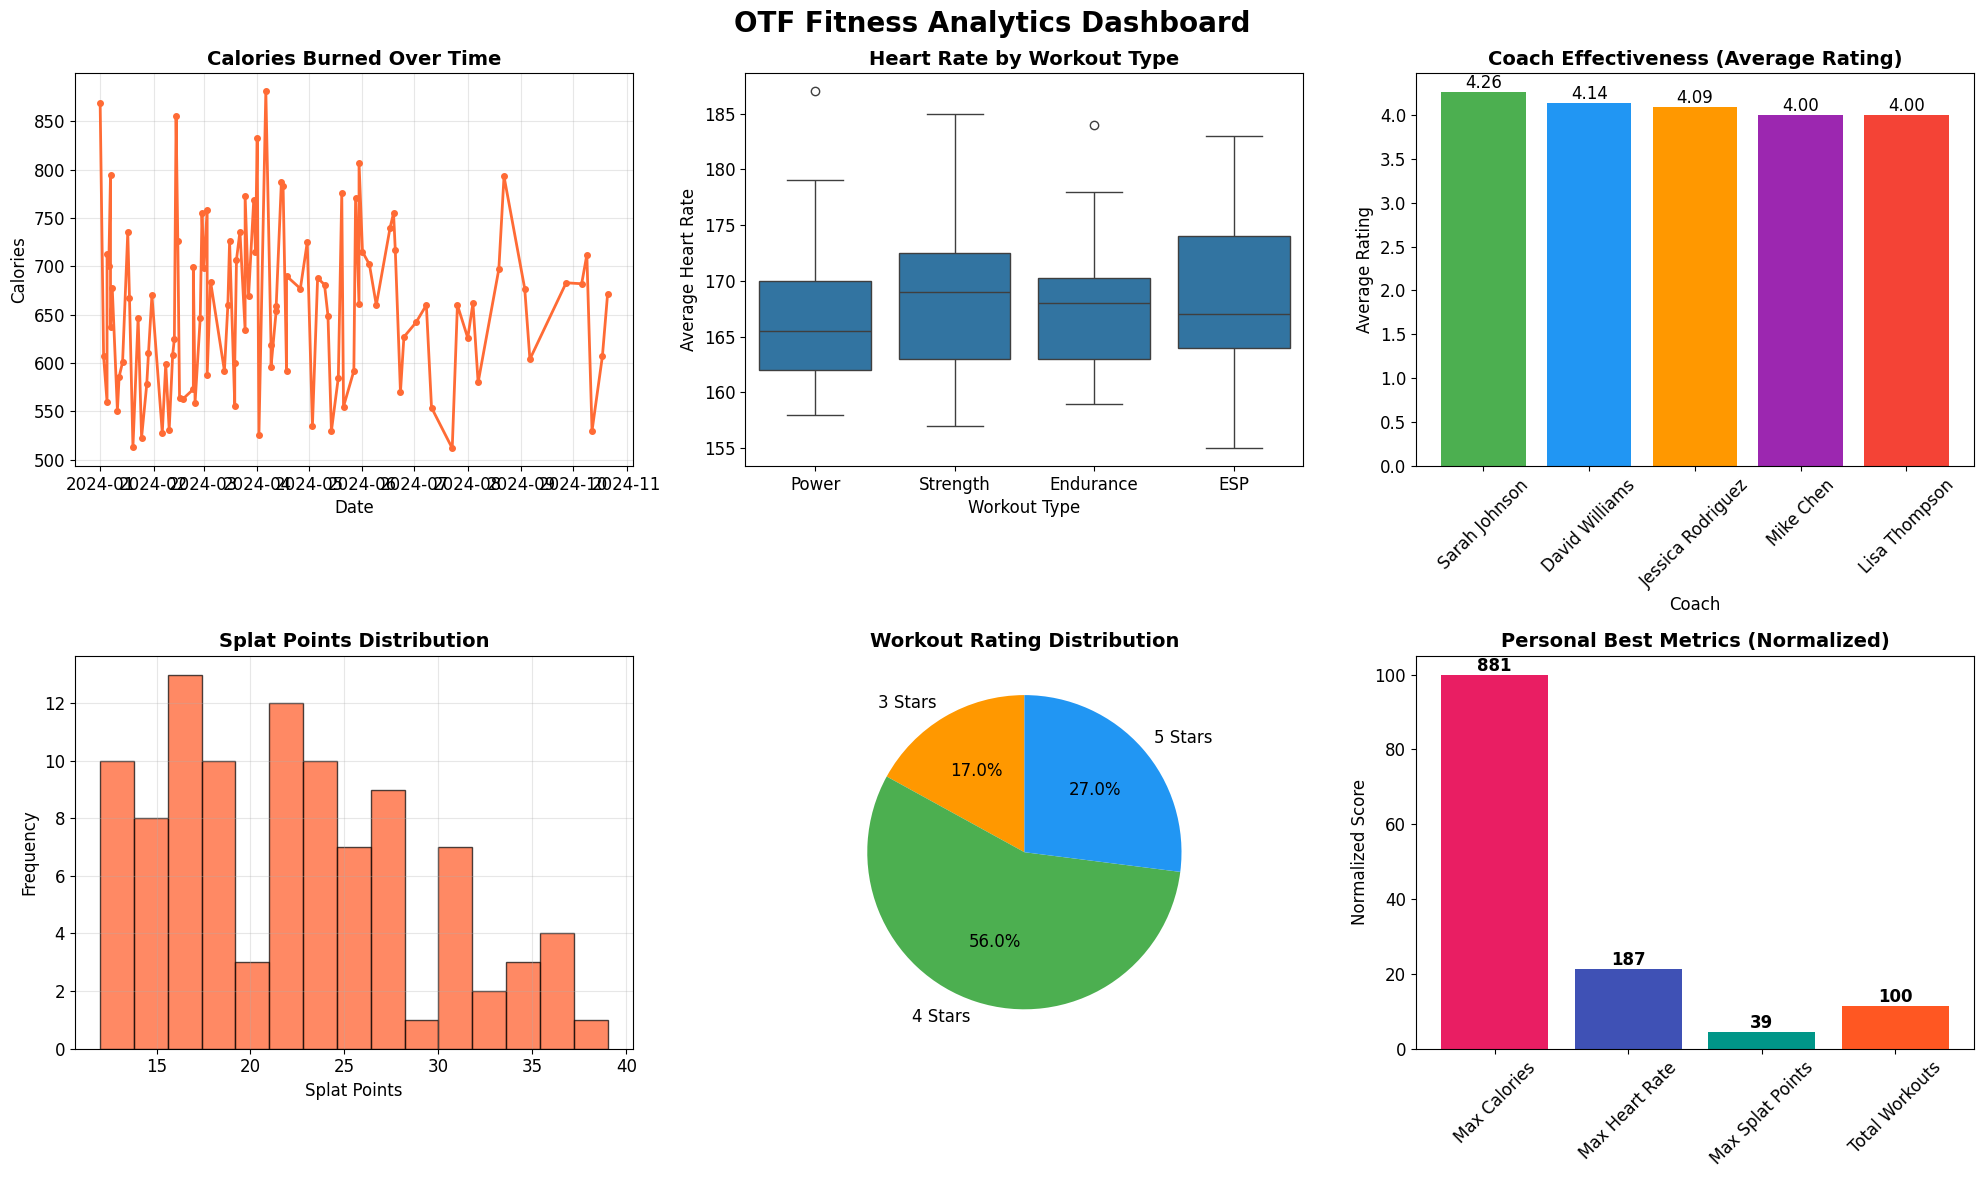

Dashboard created and saved as 'otf_fitness_dashboard.png'

Pipeline completed successfully at 2025-07-11 16:21:38.824167

SUCCESS! Check above for your fitness dashboard!
Dashboard saved as 'otf_fitness_dashboard.png'

Preparing GitHub files...

Preparing files for GitHub...
Sample data exported to 'sample_workouts.csv'
Requirements.txt created
Files ready

Done


<Figure size 1500x1000 with 0 Axes>

In [78]:
# Export functions
# Prepares  data and configuration files for uploading

def export_for_github():
    """Export sample data and requirements for GitHub"""
    print("\nPreparing files for GitHub...")

    # Export sample data
    try:
        conn = sqlite3.connect('otf_fitness.db')
        df = pd.read_sql_query("SELECT * FROM workouts LIMIT 20", conn)
        df.to_csv('sample_workouts.csv', index=False)
        conn.close()
        print("Sample data exported to 'sample_workouts.csv'")
    except Exception as e:
        print(f"Error exporting data: {e}")

    # Create requirements.txt
    requirements = """requests==2.31.0
pandas==2.0.3
matplotlib==3.7.1
seaborn==0.12.2
numpy==1.24.3
"""

    with open('requirements.txt', 'w') as f:
        f.write(requirements)
    print("Requirements.txt created")

    print("Files ready")

# EXECUTE THE PIPELINE - RUN THIS CELL!
if __name__ == "__main__":
    print("OTF Fitness Analytics - Complete Pipeline")
    print("Running main analysis...")
    main()
    print("\n" + "="*50)
    print("Preparing GitHub files...")
    export_for_github()
    print("\nDone")